In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import kagglehub
import os
import re
from datasets import load_dataset
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

/usr/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = kagglehub.dataset_download("jbalwaysus/simlex-999")

train_dataset_path = os.path.join(path, "SimLex-999.txt")

dataset_simlex = pd.read_csv(train_dataset_path, sep='\t')

print(dataset_simlex.shape)
print(dataset_simlex.head())

(999, 10)
   word1        word2 POS  SimLex999  conc(w1)  conc(w2)  concQ  Assoc(USF)  \
0    old          new   A       1.58      2.72      2.81      2        7.25   
1  smart  intelligent   A       9.20      1.75      2.46      1        7.11   
2   hard    difficult   A       8.77      3.76      2.21      2        5.94   
3  happy     cheerful   A       9.55      2.56      2.34      1        5.85   
4   hard         easy   A       0.95      3.76      2.07      2        5.82   

   SimAssoc333  SD(SimLex)  
0            1        0.41  
1            1        0.67  
2            1        1.19  
3            1        2.18  
4            1        0.93  


Main-dataset to train embedder:

In [3]:
path = kagglehub.dataset_download("thedevastator/tinystories-narrative-classification")
path = os.path.join(path, "train.csv")
dataset_stories = pd.read_csv(path)
print(dataset_stories.shape)
dataset_stories.head()

(2119719, 1)


,text
0,"One day, a little girl named Lily found a need..."
1,"Once upon a time, there was a little car named..."
2,"One day, a little fish named Fin was swimming ..."
3,"Once upon a time, in a land full of trees, the..."
4,"Once upon a time, there was a little girl name..."


note: each of these story will be considered as a documentd for embedding creations and similarity stuff

Side-dataset to train embedder:

In [4]:
if False:
	dataset_wikitext = load_dataset("wikitext", "wikitext-2-raw-v1", split="train").to_pandas()

	# Access the raw text list
	text_data = dataset_wikitext["text"]
	print(text_data[3])

 Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " Calamaty Raven " . 



In [5]:
def evaluate_embedding(embedder):
	results = []
	# look at dataset_simlex
	for index, row in tqdm(dataset_simlex.iterrows(), total=dataset_simlex.shape[0]):
		word1 = row['word1']
		word2 = row['word2']
		simlex_score = row['SimLex999']

		emb1 = embedder.get_embedding(word1)
		emb2 = embedder.get_embedding(word2)

		if emb1 is not None and emb2 is not None:
			cosine_sim = np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
			# Store or print the cosine similarity and compare with simlex_score
			results.append((word1, word2, simlex_score, cosine_sim))
	results_df = pd.DataFrame(results, columns=['word1', 'word2', 'simlex_score', 'cosine_sim'])
	results_df["sim_to_cosine"] = (results_df["simlex_score"] / 5) - 1
	return results_df

### Dataset Analysis (emb_pure_counts)

In [6]:
N_DOCS = 20000

In [7]:
tqdm.pandas()

docs_words = dataset_stories["text"].head(N_DOCS).reset_index(drop=True).progress_apply(
	lambda t: re.findall(r'\w+', t)
)
word_doc = docs_words.explode()

emb_pure_counts = pd.crosstab(word_doc, word_doc.index)
print(emb_pure_counts.shape)
emb_pure_counts.head(20)

100%|██████████| 20000/20000 [00:01<00:00, 17320.68it/s]


(13059, 20000)


col_0,0,1,2,3,4,5,6,7,8,9,...,19990,19991,19992,19993,19994,19995,19996,19997,19998,19999
text,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10th,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
123,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
164,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Compute document frequency (number of documents each term appears in)
df_word_doc = word_doc.reset_index()
df_word_doc.columns = ["doc", "word"]

# Count unique documents per word (document frequency)
doc_freq_per_term = df_word_doc.groupby("word")["doc"].nunique().sort_values(ascending=False)
print(doc_freq_per_term.shape)
doc_freq_per_term.head(20)

(13059,)


word
and      19969
a        19910
to       19857
the      19683
was      18709
day      16124
it       15840
One      14486
there    14402
in       14313
time     13864
with     13664
Once     13572
of       12896
The      12793
that     12664
had      12171
upon     12089
happy    12066
said     12005
Name: doc, dtype: int64

word
and      19969
a        19910
to       19857
the      19683
was      18709
day      16124
it       15840
One      14486
there    14402
in       14313
Name: doc, dtype: int64
word
day      16124
it       15840
One      14486
there    14402
in       14313
         ...  
7            1
6            1
œoh          1
œnow         1
œjust        1
Name: doc, Length: 13054, dtype: int64


[]

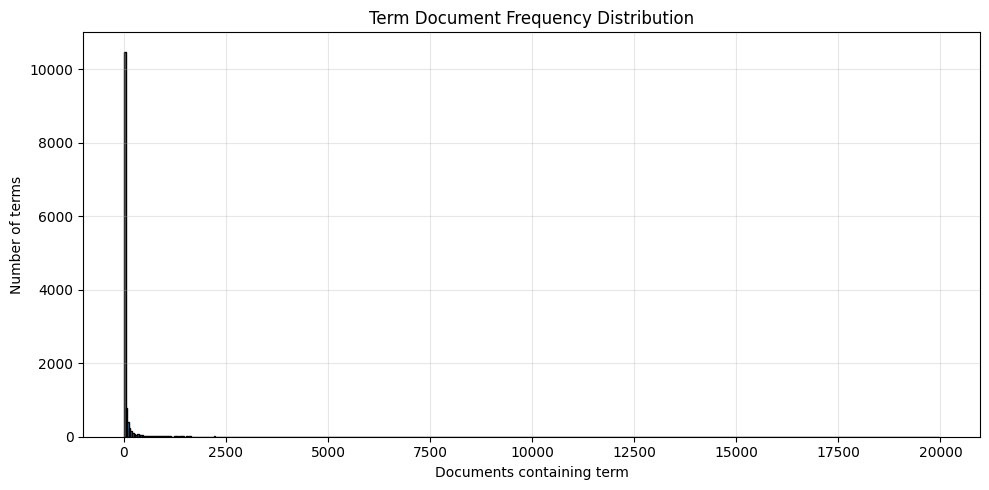

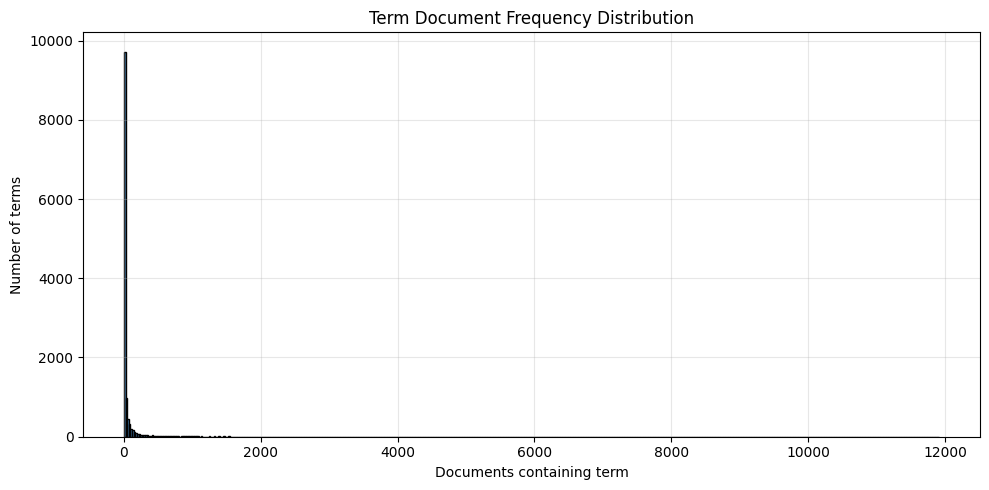

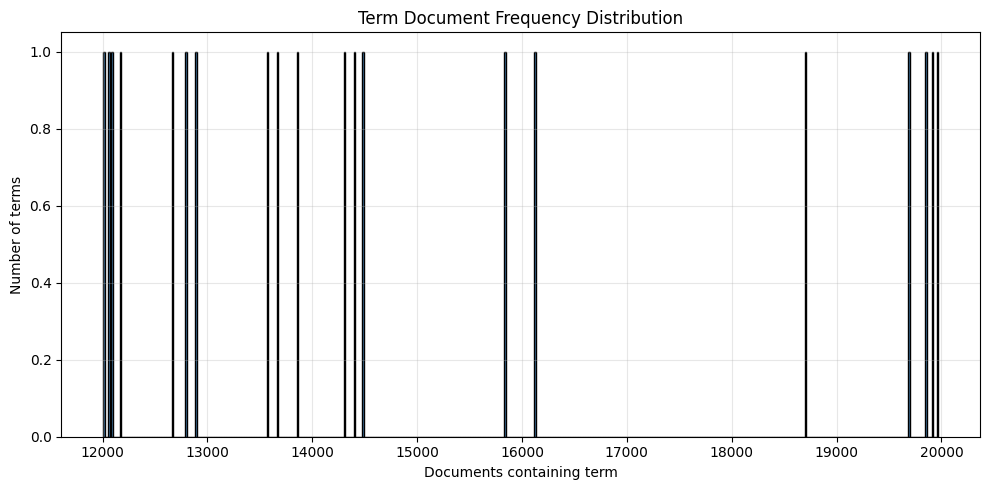

In [9]:
print(doc_freq_per_term[:10])
print(doc_freq_per_term[5:])


plt.figure(figsize=(10, 5))
plt.hist(doc_freq_per_term, bins=500, color="steelblue", edgecolor="black")
plt.xlabel("Documents containing term")
plt.ylabel("Number of terms")
plt.title("Term Document Frequency Distribution")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.plot()

plt.figure(figsize=(10, 5))
plt.hist(doc_freq_per_term[20:], bins=500, color="steelblue", edgecolor="black")
plt.xlabel("Documents containing term")
plt.ylabel("Number of terms")
plt.title("Term Document Frequency Distribution")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.plot()

plt.figure(figsize=(10, 5))
plt.hist(doc_freq_per_term[:20], bins=500, color="steelblue", edgecolor="black")
plt.xlabel("Documents containing term")
plt.ylabel("Number of terms")
plt.title("Term Document Frequency Distribution")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.plot()

## Sparse-Embeddings

Baseline embedder

### Random Embeddings

In [10]:
class RandomEmbedder:
	def __init__(self, dim=100):
		self.dim = dim

	def get_embedding(self, word):
		np.random.seed(hash(word) % (2**32))
		return np.random.rand(self.dim)

In [11]:
embRandom = RandomEmbedder(dim=100)
df_results_random = evaluate_embedding(embRandom)
print(f"Average cosine similarity vs SimLex-999 score correlation: {np.mean(df_results_random['cosine_sim'] - df_results_random['sim_to_cosine'])}")

100%|██████████| 999/999 [00:00<00:00, 7938.85it/s]

Average cosine similarity vs SimLex-999 score correlation: 0.8383056261248386


### Raw-Counting Embeddings

Each row is the embedding of each word, over the training vocabularies

In [12]:
class RawCounting:
	def __init__(self, emb_matrix):
		self.emb_matrix = emb_matrix

	def get_embedding(self, word):
		if word in self.emb_matrix.index:
			return self.emb_matrix.loc[word].values
		else:
			return None

In [13]:
embRawCounting = RawCounting(emb_pure_counts)

df_results_counting = evaluate_embedding(embRawCounting)

print(f"Average cosine similarity vs SimLex-999 score correlation: {np.mean(df_results_counting['cosine_sim'] - df_results_counting["sim_to_cosine"])}")

100%|██████████| 999/999 [00:02<00:00, 357.14it/s]

Average cosine similarity vs SimLex-999 score correlation: 0.18033735285271713


### Raw-Counting + PCA Embeddings

In [14]:
class RawCountingPCA:
	def __init__(self, emb_matrix):
		self.pca = PCA(n_components=100)
		self.emb_matrix = pd.DataFrame(self.pca.fit_transform(emb_matrix), index=emb_matrix.index)

	def get_embedding(self, word):
		if word in self.emb_matrix.index:
			return self.emb_matrix.loc[word].values
		else:
			return None

In [15]:
if False: # Care, the PCA takes a lot
	embRawCountingPCA = RawCountingPCA(emb_pure_counts)

	df_results_counting_pca = evaluate_embedding(embRawCountingPCA)

	print(f"Average cosine similarity vs SimLex-999 score correlation: {np.mean(df_results_counting_pca['cosine_sim'] - df_results_counting_pca["sim_to_cosine"])}")

100%|██████████| 999/999 [00:00<00:00, 21205.65it/s]

Average cosine similarity vs SimLex-999 score correlation: 0.34707417814227487


### TF-IDF Embeddings

In [17]:
class TfIdf:
    def __init__(self, emb_matrix):
        self.emb_matrix = pd.DataFrame(emb_matrix, index=emb_matrix.index)
        
        # TF
        tf = self.emb_matrix.copy().astype(float)
        mask = tf > 0
        tf[mask] = 1 + np.log10(tf[mask])
        
        # IDF
        N = self.emb_matrix.shape[1]
        df = (self.emb_matrix > 0).sum(axis=1)
        idf = np.log10(N / df)
        
        # TF-IDF
        self.emb_matrix = tf.multiply(idf, axis=0)

    def get_embedding(self, word):
        if word in self.emb_matrix.index:
            return self.emb_matrix.loc[word].values
        else:
            return None

In [18]:
embRawCounting = TfIdf(emb_pure_counts)

df_results_tfidf = evaluate_embedding(embRawCounting)

print(f"Average cosine similarity vs SimLex-999 score correlation: {np.mean(df_results_tfidf['cosine_sim'] - df_results_tfidf["sim_to_cosine"])}")

100%|██████████| 999/999 [00:00<00:00, 3445.18it/s]

Average cosine similarity vs SimLex-999 score correlation: 0.1872408186897673


### PMI Embedding

In [20]:
class PMI:
    def __init__(self, co_occurrence_matrix):
        matrix = co_occurrence_matrix.values
        total_count = matrix.sum()
        
        # Joint Probability
        p_xy = matrix / total_count
        
        # Marginal Probabilities
        p_x = p_xy.sum(axis=1)
        p_y = p_xy.sum(axis=0)
        
        with np.errstate(divide='ignore', invalid='ignore'):
            pmi = np.log2(p_xy) - np.log2(p_x[:, None]) - np.log2(p_y[None, :])
        
        self.emb_matrix = pd.DataFrame(pmi, index=co_occurrence_matrix.index)

    def get_embedding(self, word):
        if word in self.emb_matrix.index:
            return self.emb_matrix.loc[word].values
        else:
            return None

In [ ]:
cooc_matrix = emb_pure_counts.dot(emb_pure_counts.T)
embPMI = PMI(cooc_matrix)

df_results_pmi = evaluate_embedding(embPMI)
print(f"Average cosine similarity vs SimLex-999 score correlation: {np.mean(df_results_pmi['cosine_sim'] - df_results_pmi['sim_to_cosine'])}")

### PMI K-Smoothing Embedding

In [ ]:
class PPMIKSmooth:
    def __init__(self, co_occurrence_matrix, k=0):
        matrix = co_occurrence_matrix.values.astype(float)
        
        if k > 0:
            matrix += k
            
        total_count = matrix.sum()
        
        # Joint Probability
        p_xy = matrix / total_count
        
        # Marginal Probabilities
        p_x = p_xy.sum(axis=1)
        p_y = p_xy.sum(axis=0)
        
        with np.errstate(divide='ignore', invalid='ignore'):
            pmi = np.log2(p_xy) - np.log2(p_x[:, None]) - np.log2(p_y[None, :])
        
        # PPMI
        pmi[pmi < 0] = 0
        pmi[np.isnan(pmi)] = 0
        pmi[np.isinf(pmi)] = 0
        
        self.emb_matrix = pd.DataFrame(pmi, index=co_occurrence_matrix.index)

    def get_embedding(self, word):
        if word in self.emb_matrix.index:
            return self.emb_matrix.loc[word].values
        else:
            return None

In [ ]:
cooc_matrix = emb_pure_counts.dot(emb_pure_counts.T)

embPPMI = PPMIKSmooth(cooc_matrix, k=1.0)

df_results_ppmi = evaluate_embedding(embPPMI)
print(f"Average cosine similarity vs SimLex-999 score correlation: {np.mean(df_results_ppmi['cosine_sim'] - df_results_ppmi['sim_to_cosine'])}")

### PPMI Embedding

In [ ]:
class PPMI:
    def __init__(self, co_occurrence_matrix):
        matrix = co_occurrence_matrix.values
        total_count = matrix.sum()
        
        # Joint Probability
        p_xy = matrix / total_count
        
        # Marginal Probabilities
        p_x = p_xy.sum(axis=1)
        p_y = p_xy.sum(axis=0)
        
        with np.errstate(divide='ignore', invalid='ignore'):
            pmi = np.log2(p_xy) - np.log2(p_x[:, None]) - np.log2(p_y[None, :])
        
        # PPMI
        pmi[pmi < 0] = 0
        pmi[np.isnan(pmi)] = 0
        pmi[np.isinf(pmi)] = 0
        
        self.emb_matrix = pd.DataFrame(pmi, index=co_occurrence_matrix.index)

    def get_embedding(self, word):
        if word in self.emb_matrix.index:
            return self.emb_matrix.loc[word].values
        else:
            return None

In [ ]:
cooc_matrix = emb_pure_counts.dot(emb_pure_counts.T)
embPPMI = PPMI(cooc_matrix)

df_results_ppmi = evaluate_embedding(embPPMI)
print(f"Average cosine similarity vs SimLex-999 score correlation: {np.mean(df_results_ppmi['cosine_sim'] - df_results_ppmi['sim_to_cosine'])}")

### PPMI K-Smoothing Embedding

In [ ]:
class PPMIKSmooth:
    def __init__(self, co_occurrence_matrix, k=0):
        matrix = co_occurrence_matrix.values.astype(float)
        
        if k > 0:
            matrix += k
            
        total_count = matrix.sum()
        
        # Joint Probability
        p_xy = matrix / total_count
        
        # Marginal Probabilities
        p_x = p_xy.sum(axis=1)
        p_y = p_xy.sum(axis=0)
        
        with np.errstate(divide='ignore', invalid='ignore'):
            pmi = np.log2(p_xy) - np.log2(p_x[:, None]) - np.log2(p_y[None, :])
        
        # PPMI
        pmi[pmi < 0] = 0
        pmi[np.isnan(pmi)] = 0
        pmi[np.isinf(pmi)] = 0
        
        self.emb_matrix = pd.DataFrame(pmi, index=co_occurrence_matrix.index)

    def get_embedding(self, word):
        if word in self.emb_matrix.index:
            return self.emb_matrix.loc[word].values
        else:
            return None

In [ ]:
cooc_matrix = emb_pure_counts.dot(emb_pure_counts.T)

embPPMI = PPMI(cooc_matrix, k=1.0)

df_results_ppmi = evaluate_embedding(embPPMI)
print(f"Average cosine similarity vs SimLex-999 score correlation: {np.mean(df_results_ppmi['cosine_sim'] - df_results_ppmi['sim_to_cosine'])}")